# Life-Cycle Labor Supply

Solves and simulates a $T$-period labor supply model with consumption-saving in Keane(2016).

The **Bellman equation** and the recursive formulation of the model is 

$$
\begin{align}
V_{t}(a_{t},k_{t})=&\max_{c_{t},h_{t}}\frac{c_{t}^{1+\eta}}{1+\eta}-\beta\frac{h_{t}^{1+\gamma}}{1+\gamma}+\rho V_{t+1}(a_{t+1},k_{t+1}) \\
& \text{s.t.} \\
a_{t+1}=&(1+r)(a_{t}+(1-\tau)w_{t}h_{t}-c_{t}) \\
k_{t+1} =&k_{t}+h_{t}
\end{align}
$$
such that wages are endogenous
$$
\begin{align}
w_{t}&=w\left(1+\alpha k_{t}\right)\\
&=w\left(1+\alpha\sum_{s=1}^{t-1}h_{s}\right).
\end{align}
$$

We will solve this by **backwards induction**, assuming no bequest motive. The last-period problem becomes
$$
\begin{align}
V_{T}(a_T,k_T)=&\max_{h_{T}}\frac{c_{T}^{1+\eta}}{1+\eta}-\beta\frac{h_{T}^{1+\gamma}}{1+\gamma} \\
& \text{s.t.} \\
c_T = &a_{T}+(1-\tau)w_{T}h_{T}.
\end{align}
$$

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Consumption-Saving Model

In [2]:
# load local model file and initialize model class
from DynLaborModel import DynLaborModelClass
model = DynLaborModelClass(par={'T':2,'r':0.02,'rho':1/(1.02)}) # set a few number of periods. VERY slow.

In [3]:
par = model.par
sol = model.sol
sim = model.sim

**Grids:** $\overrightarrow{a}$ and $\overrightarrow{k}$

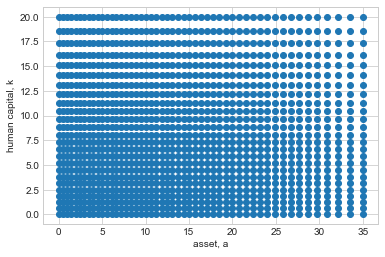

In [4]:
fig, ax = plt.subplots()
a_mesh,k_mesh = np.meshgrid(par.a_grid,par.k_grid,indexing='ij')
ax.scatter(a_mesh,k_mesh)
ax.set(xlabel='asset, a',ylabel='human capital, k');

## Solve the model

In [ ]:
model.solve()

**Last period, $t=T$**

In [ ]:
# last period
t = par.T-1
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, k_mesh, sol.c[t],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Consumption, $c_{T}^{\star}$');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, k_mesh, sol.h[t],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Hours, $h_{T}^{\star}$');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, k_mesh, sol.V[t],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Value, $V_{T}$');

In [ ]:
# first period
t = 0
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, k_mesh, sol.c[t],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Consumption, $c_{T}^{\star}$');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, k_mesh, sol.h[t],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Hours, $h_{T}^{\star}$');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, k_mesh, sol.V[t],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Value, $V_{T}$');

**Question 1:** 

## In-class exercise

1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question

## Simulation

With the solution at hand we can now simulate `simN` synthetic individuals for `simT` periods. We do so by initializing all state-variables in the first period and simulate forwards. 

Initial wealth and human capital are the state variables in our model, and we start by initilizing all individuals with no wealth, `sim.a_init=np.zeros(par.simN)` and no human capital `sim.k_init=np.zeros(par.simN)`. We then loop forward using the solution:
$$
\begin{align}
c_{i,t} &= c_t^{\star}(a_{i,t},k_{i,t}) \\
h_{i,t} &= h_t^{\star}(a_{i,t},k_{i,t}) \\
y_{i,t} &= (1-\tau) \cdot  w\cdot(1+\alpha k_{i,t}) \cdot h_{i,t}\\
a_{i,t+1} &= (1+r)(a_{i,t} + y_{i,t} - c_{i,t})\\
k_{i,t+1} &= k_{i,t} + h_{i,t}\\
\end{align}
$$

In [ ]:
model.simulate()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(sim.c,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. consumption',ylim=[0,2],xticks=range(par.simT));

In [ ]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(sim.a,axis=0))
ax.set(xlabel='period, t',ylabel='Avg. assets',ylim=[0,2],xticks=range(par.simT));

**Question 2:** 

**Question 3:** 

**Question 4:**

## In-class exercise

1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question